# Tik tok data analysis and content classification
This project provides a concrete example of a typical Machine Learning engineering problem. The dataset, known as TikTok, contains video data, including interaction analysis and transcripts. The objective is to classify each video as either a **claim** or an **opinion**.

Tasks performed in this project include:
1. Exploratory analysis of the dataset, including numerical, categorical, and text attributes.
2. Implementation of a data preprocessing pipeline, incorporating Keras preprocessing layers.
3. Implementation of a neural network to perform the classification
4. Training the model and identifying the optimal set of weights
5. Evaluation of the model
6. Examples of use of the trained model

## 1. Exploratory data analysis
We start by loading basic libraries, then we read the data set. Note that columns `#` and `vide_id` are eliminated from the analysis, since they do not provide relevant information for the classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'tiktok_dataset.csv'
data = pd.read_csv(data_path)

# eliminamos las columnas no deseadas (# y video_id)
data = data.drop(['#', 'video_id'], axis=1)

data.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,claim,59,someone shared with me that drone deliveries a...,not verified,under review,343296,19425,241,1,0
1,claim,32,someone shared with me that there are more mic...,not verified,active,140877,77355,19034,1161,684
2,claim,31,someone shared with me that american industria...,not verified,active,902185,97690,2858,833,329
3,claim,25,someone shared with me that the metro of st. p...,not verified,active,437506,239954,34812,1234,584
4,claim,19,someone shared with me that the number of busi...,not verified,active,56167,34987,4110,547,152


Subsequently, we can observe that there are no null or missing values ​​in the dataset:

In [3]:
# revisar nulls
data.isnull().sum()

claim_status                0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

First, the following figure shows the distribution of values ​​for the attribute `video_duration_sec`, for the claim and opinion classes. As expected, both classes have a similar distribution, so this attribute does not contain relevant information for classification, so it is eliminated from the data set.

<Axes: xlabel='video_duration_sec', ylabel='Count'>

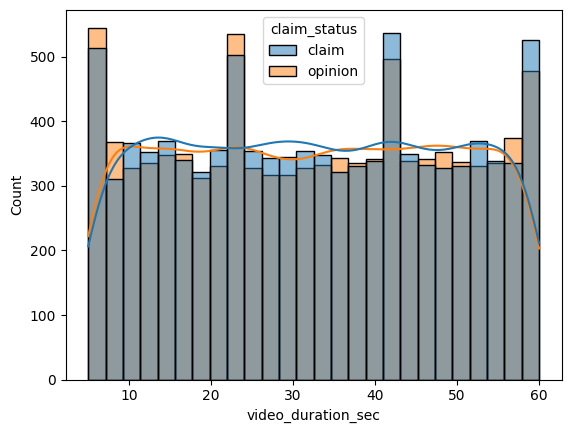

In [4]:
# en general las vistas tienen una distribucion similar en ambas clases
sns.histplot(data, x='video_duration_sec', hue='claim_status', kde=True)

In [5]:
# por lo cual las eliminamos del analisis
data = data.drop('video_duration_sec', axis=1)

When performing a basic statistical analysis, we realize that the numerical attributes contain values ​​in a wide range, and also have a high standard deviation, which makes the learning process in neural networks difficult. Consequently, it is necessary to perform a normalization process on these attributes.

In [6]:
# descripcion de datos numericos (analitics)
data.describe()

,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Finally, the following figure illustrates the relationship between pairs of numerical attributes, where each class is denoted in different colors. Note that **opinion** instances have lower values ​​in all attributes, while **complaint** instances have higher values. This information reveals that numerical (`video_view_count`, `video_like_count`, `video_share_count`, `video_download_count` and `video_comment_count`) attributes contain valuable information for classification. Therefore, in this example they are considered as part of the analysis, in addition to including information from video transcripts (`video_transcription_text`) and author data (`verified_status`, `author_ban_status`).

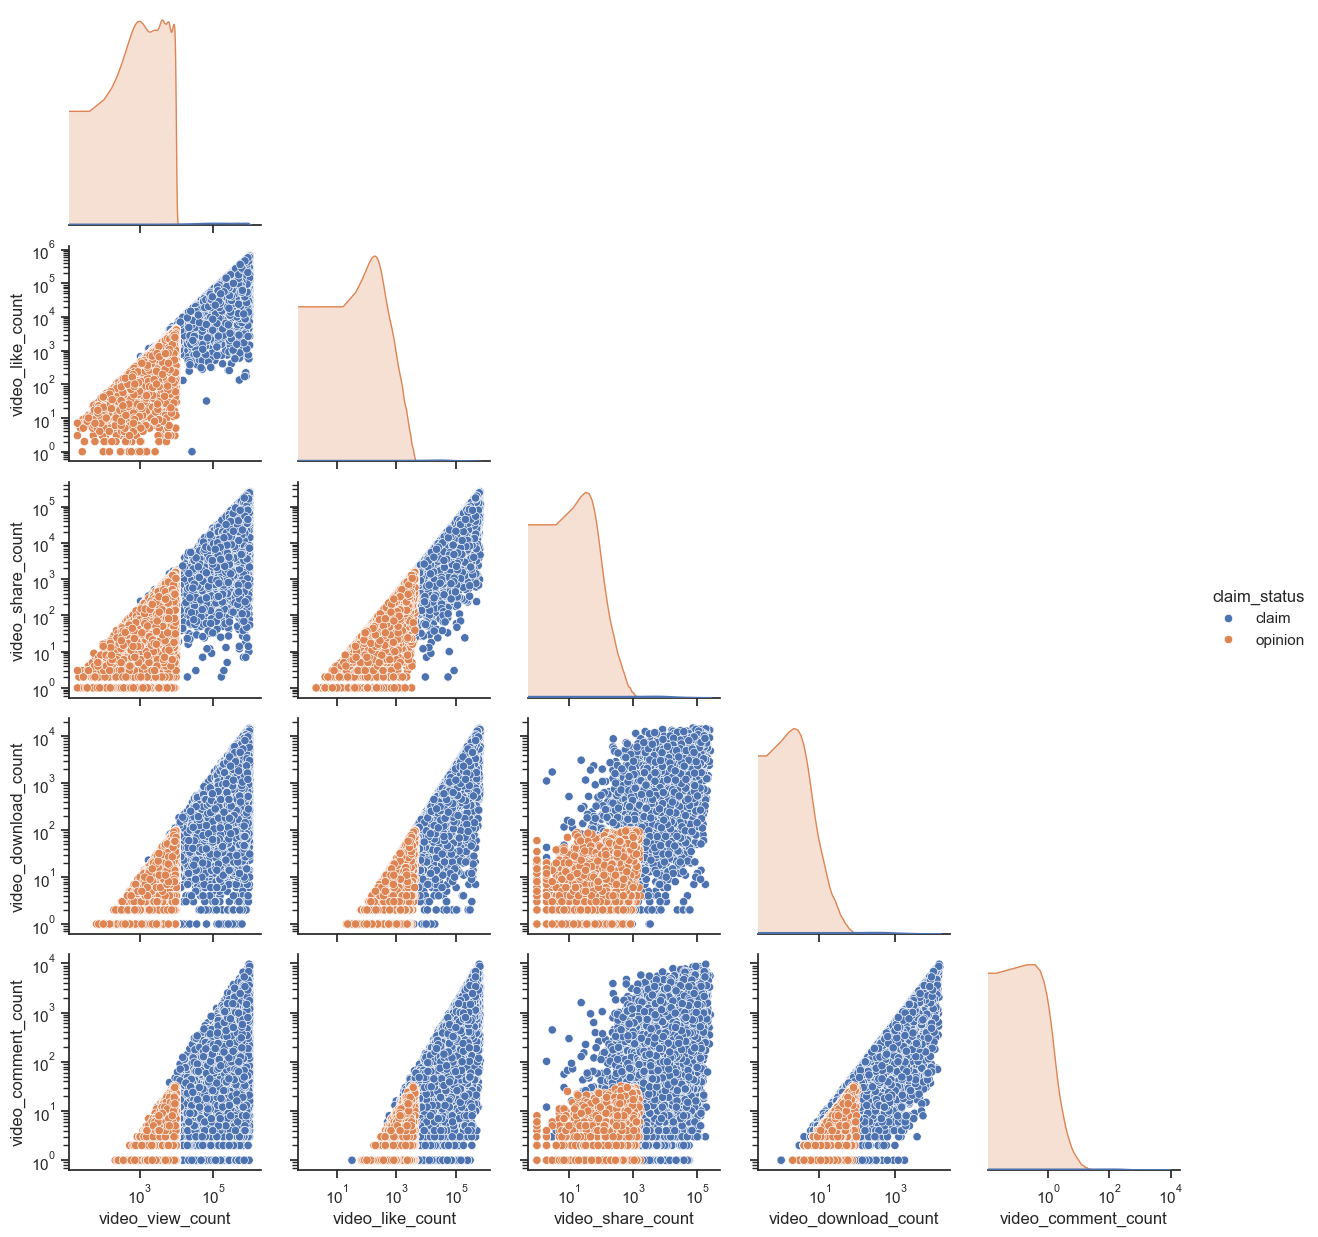

In [6]:
# inspeccion de los atributos numericos de interes (analitics)
sns.set_theme(style='ticks')
g = sns.pairplot(data, hue='claim_status', corner=True)

g.set(xscale="log")
g.set(yscale="log")

## 2. Data preprocessing pipeline

Regarding the preprocessing pipeline, a function is implemented to transform a Pandas Dataframe into a Tensorflow Dataset, note that this process includes data batching. This function is then applied to data splitting, including training, validation, and test sets.

In [14]:
def df_to_dataset(dataframe, y_label, batch=1):
  dataframe = dataframe.copy()
  labels = dataframe.pop(y_label).values
  _, labels = np.unique(labels,  return_inverse=True)
  
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) 
  return ds.batch(batch)

# split de datos
train, test = train_test_split(data, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.2, random_state=1)

# convertir a Dataset
BATCH_SIZE = 16
train = df_to_dataset(train, y_label='claim_status', batch=BATCH_SIZE)
test = df_to_dataset(test, y_label='claim_status', batch=BATCH_SIZE)
val = df_to_dataset(val, y_label='claim_status', batch=BATCH_SIZE)

print('Number of instances on:')
print(f'- train: {BATCH_SIZE*len(train)}')
print(f'- val: {BATCH_SIZE*len(val)}')
print(f'- test: {BATCH_SIZE*len(test)}')

Number of instances on:
- train: 12224
- val: 3056
- test: 3824


A function is implemented to prepare the data preprocessing pipeline, depending on the characteristics of the data. For numeric values, a `Normalization` layer is used to keep the values ​​in a normal distribution. For categorical attributes, a `StringLookup` layer is used, which transforms the input values ​​into a one-hot encoding representation. Finally, for strings, a `TextVectorization` layer is used to transform the input text into a numeric representation, where each integer represents a word in a vocabulary containing the most frequently used words in the dataset.

In [15]:
# input pipeline
def preprocessing_layer(name, dataset, type, max_tokens=10000, output_length=20):
    # accede a la feature deseada
    feature_ds = dataset.map(lambda x, y: x[name])
    
    if type=='numeric':
        auxIn = tf.keras.Input(shape=(1,), name=name, dtype='int64')
        layer = tf.keras.layers.Normalization(axis=None)
        layer.adapt(feature_ds)
    elif type=='categorical':
        auxIn = tf.keras.Input(shape=(1,), name=name, dtype='string')
        layer = tf.keras.layers.StringLookup(num_oov_indices=0, output_mode='one_hot')
        layer.adapt(feature_ds)
    elif type=='text':
        auxIn = tf.keras.Input(shape=(1,), name=name, dtype='string')
        layer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_length)
        layer.adapt(feature_ds)
    
    encoded = layer(auxIn)

    return auxIn, encoded

This function is applied to all attributes and is adapted to the information in the training set. Note that all features receive information with an input layer, which is then evaluated with its respective preprocessing layer.Consequently, neural networks can process raw inputs, as the preprocessing process is performed during model evaluation.

In [16]:
# creacion de inputs pertenecientes a interesacciones y texto, por separado
inputs = []
encoded_inputs = []

# interacciones (variables continuas)
numerical = ['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count',
             'video_comment_count']
for ni in numerical:
    auxIn, auxEn = preprocessing_layer(name=ni, dataset=train, type='numeric')
    inputs.append(auxIn)
    encoded_inputs.append(auxEn)

# datos del autor (categoricos)
categorical = ['verified_status', 'author_ban_status']
for ci in categorical:
    auxIn, auxEn = preprocessing_layer(name=ci, dataset=train, type='categorical')
    inputs.append(auxIn)
    encoded_inputs.append(auxEn)

# texto de la transcripcion
textIn, textEn = preprocessing_layer(name='video_transcription_text', dataset=train, type='text')
textEn = tf.cast(textEn, tf.float32) # cast a float 32
inputs.append(textIn)
encoded_inputs.append(textEn)

## 3. Implementation of classification model
A neural network is implemented to perform the classification task. Note that the model evaluates its inputs with the preprocessing layer and then the results are evaluated with layers of fully-conected neurons. In this case, the text attribute (`video_transcription_text`) is treated separately from the rest of the features. Then, at the end of the network, all the features are concatenated to perform the classification.

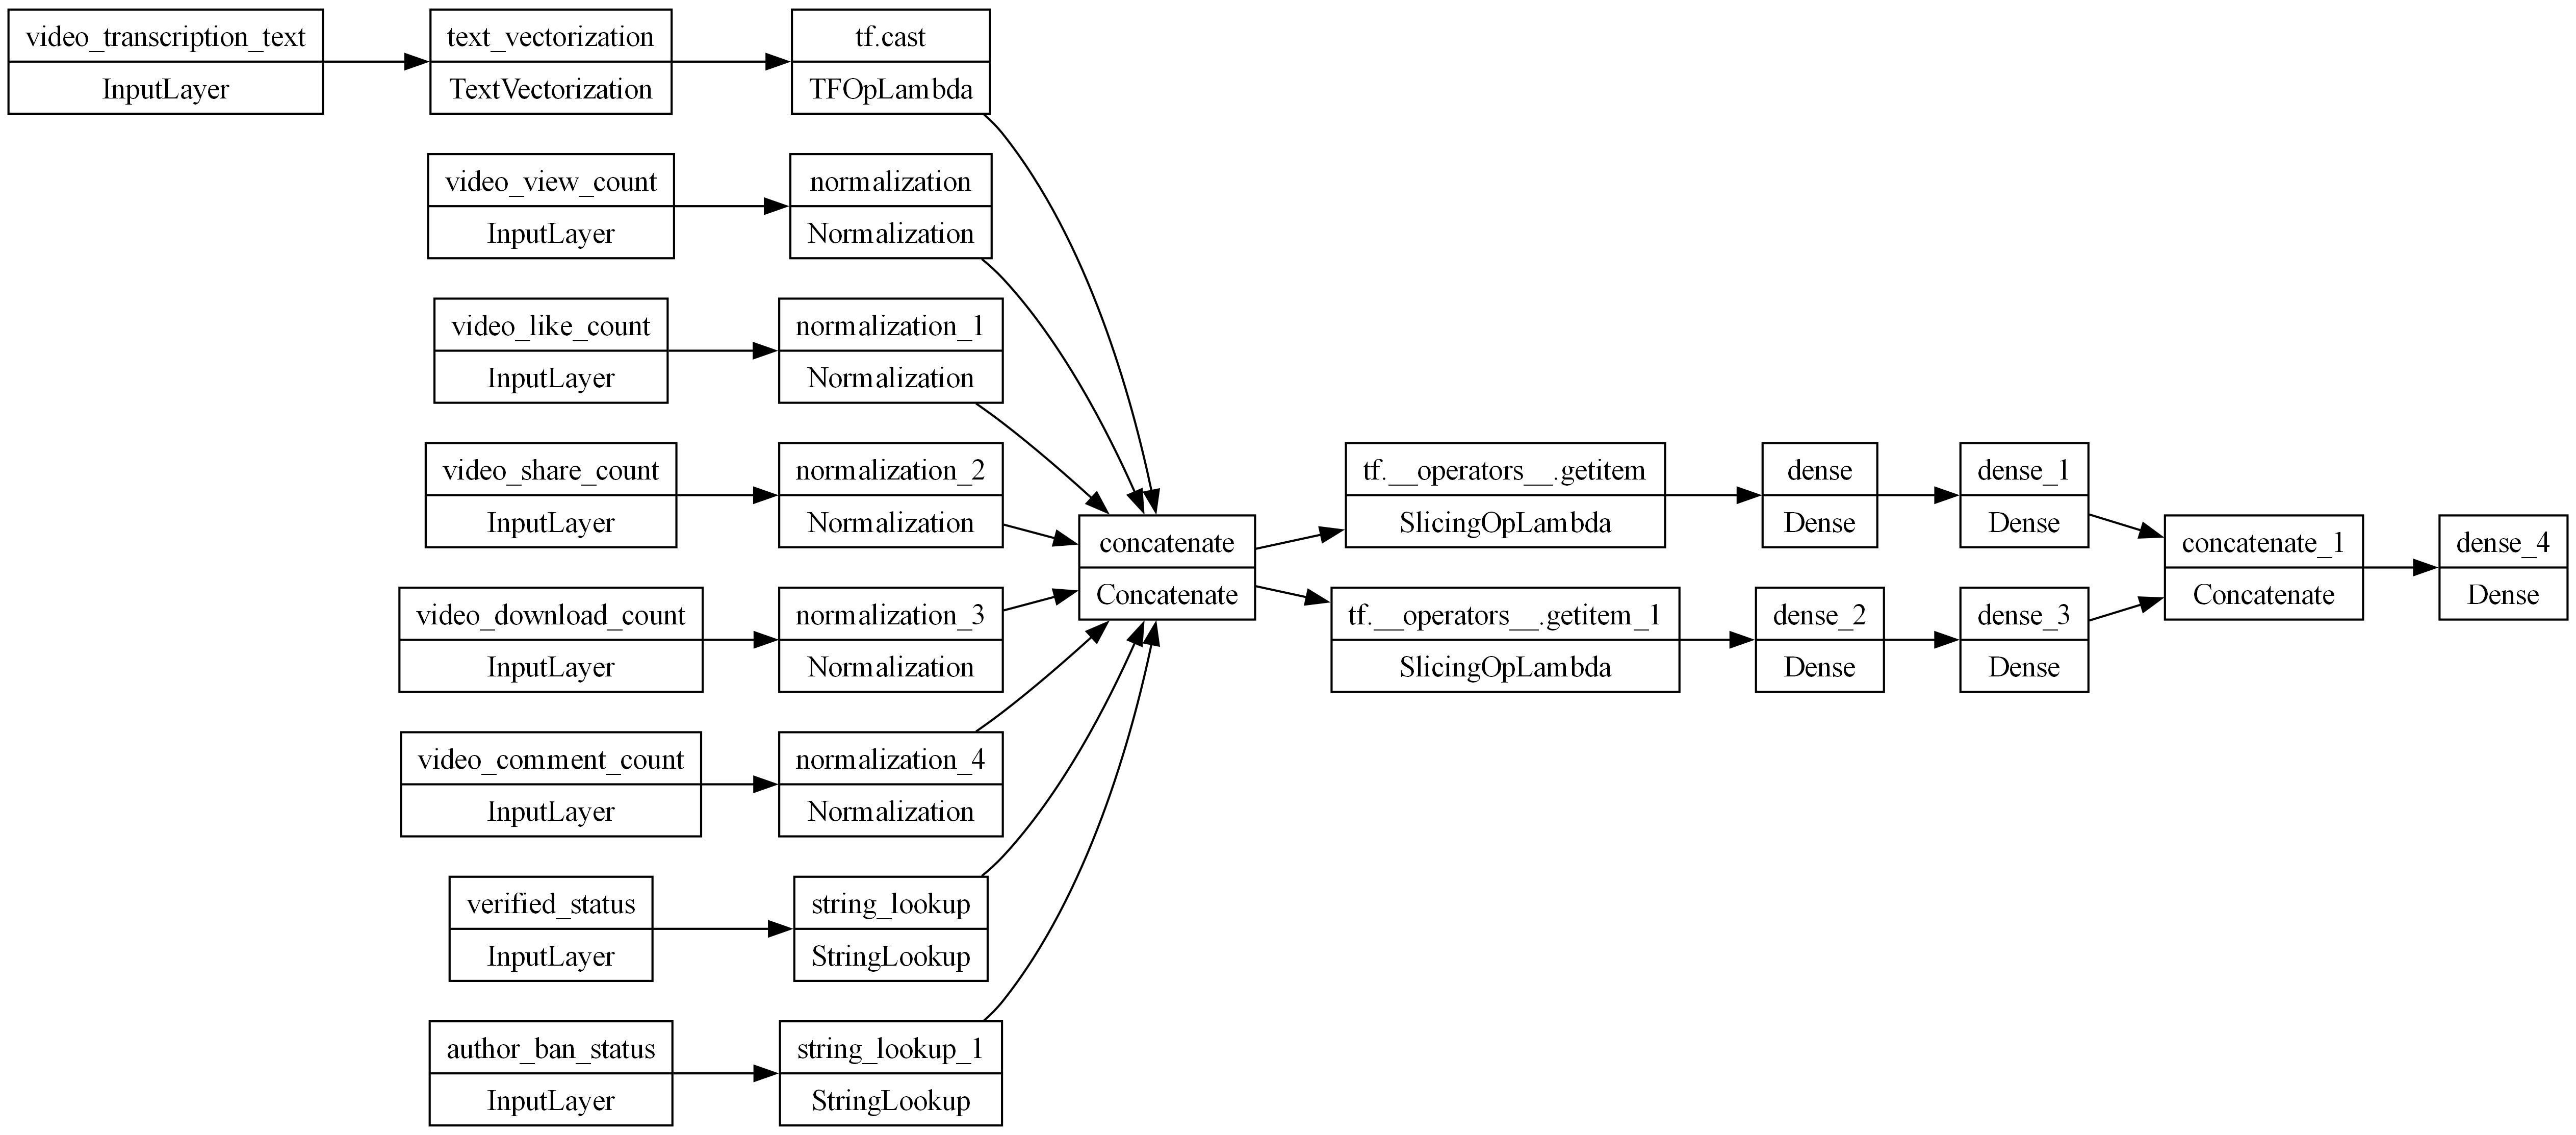

In [18]:
concat_encoded = tf.keras.layers.Concatenate(axis=-1)(encoded_inputs)

# modelo numerical
nums = concat_encoded[:,:-20]
nd1 = tf.keras.layers.Dense(32, 'relu')(nums)
nd2 = tf.keras.layers.Dense(16, 'relu')(nd1)

# modelo texto
text = concat_encoded[:,-20:]
td1 = tf.keras.layers.Dense(32, 'relu')(text)
td2 = tf.keras.layers.Dense(16, 'relu')(td1)

# concat
full_concat = tf.keras.layers.Concatenate(axis=-1)([nd2, td2])

# classificacion
out = tf.keras.layers.Dense(units=1, activation='sigmoid')(full_concat)

# model definition
model = tf.keras.Model(inputs, out)

# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR", dpi=300)

## 4. Model training
Regarding the model traning, a custom Callback is implemented, which, during training, identifies the epoch in which the architecture obtains the highest accuracy on the validation set. This callback is then used during training to identify the configuration that performs best with information not included in the training (`val`). In this way, overfitting problems are avoided.

In [19]:
class MaxAccEpoch(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super().__init__()
        self.epochs = epochs # number of epochs
        self.val_loss = [] # loss functions data

        self.max_epoch = 0
        self.max_val_acc = 0.0
        self.max_weights = None

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_acc') > self.max_val_acc:
            self.max_epoch = epoch
            self.max_val_acc = logs.get('val_acc')
            self.max_weights = self.model.get_weights()
        self.val_loss.append(logs.get('val_loss'))

        return super().on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        return super().on_train_end(logs)
    
EPOCHS = 20
cb = MaxAccEpoch(EPOCHS)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=['acc'])
metrics = model.fit(x=train, validation_data=val, epochs=EPOCHS, callbacks=cb)

Epoch 1/20
764/764 [==============================] - 11s 11ms/step - loss: 2.3888 - acc: 0.8577 - val_loss: 0.1115 - val_acc: 0.9686
Epoch 2/20
764/764 [==============================] - 8s 11ms/step - loss: 0.0904 - acc: 0.9758 - val_loss: 0.0535 - val_acc: 0.9895
Epoch 3/20
764/764 [==============================] - 9s 11ms/step - loss: 0.0609 - acc: 0.9838 - val_loss: 0.0445 - val_acc: 0.9902
Epoch 4/20
764/764 [==============================] - 9s 11ms/step - loss: 0.0525 - acc: 0.9859 - val_loss: 0.0373 - val_acc: 0.9905
Epoch 5/20
764/764 [==============================] - 9s 12ms/step - loss: 0.0482 - acc: 0.9864 - val_loss: 0.0325 - val_acc: 0.9915
Epoch 6/20
764/764 [==============================] - 8s 11ms/step - loss: 0.0445 - acc: 0.9878 - val_loss: 0.0302 - val_acc: 0.9921
Epoch 7/20
764/764 [==============================] - 8s 10ms/step - loss: 0.0412 - acc: 0.9887 - val_loss: 0.0318 - val_acc: 0.9921
Epoch 8/20
764/764 [==============================] - 8s 10ms/step -

Below are the results obtained during the training of the model, including the results on the train and val sets.

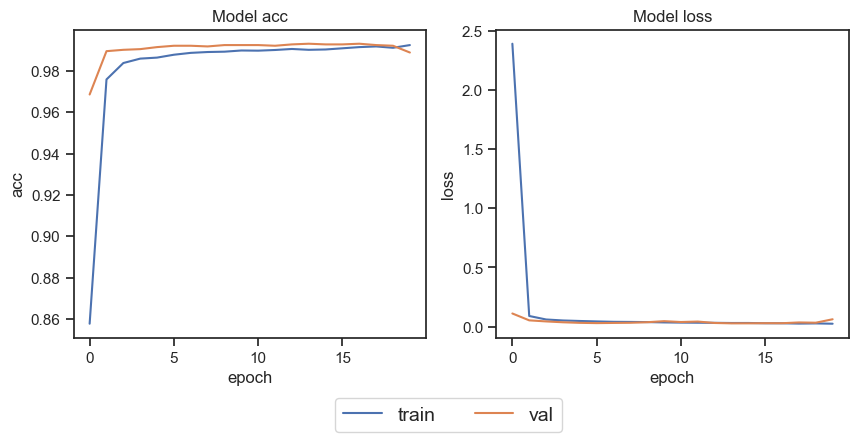

In [20]:
# plot de accuracy y loss
fig, axs = plt.subplots(1,2)
fig.set_size_inches((10,4))

labs = ['acc', 'loss']

for i, li in enumerate(labs):
    axs[i].plot(metrics.history[li], label='train')
    axs[i].plot(metrics.history[f'val_{li}'], label='val')

    axs[i].set_title(f'Model {li}')
    axs[i].set_ylabel(li)
    axs[i].set_xlabel('epoch')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='outside lower center', ncol=2, labelspacing=0., fontsize=14)

plt.show()

Note that the accuracy of the value set starts to decrease in last training epochs, which is attributed to the overfitting problem. For this reason, the callback is used to retrieve the configuration of the model that performed the best.

In [21]:
# se toma el modelo con el mejor accuracy
print(f'Optimal EPOCH: {cb.max_epoch}')
model.set_weights(cb.max_weights)

Optimal EPOCH: 13


## 5. Evaluation of the model
Finally, under the optimal configuration, the model is evaluated. This analysis includes the accuracy, the F1-Score and the confusion matrix obtained with the predictions made under the test set.

239/239 [==============================] - 1s 5ms/step
Loss on Test set: 0.05289480462670326
Accuracy on Test set: 0.9913544654846191
F1-Score on test set: 0.9912582781456953


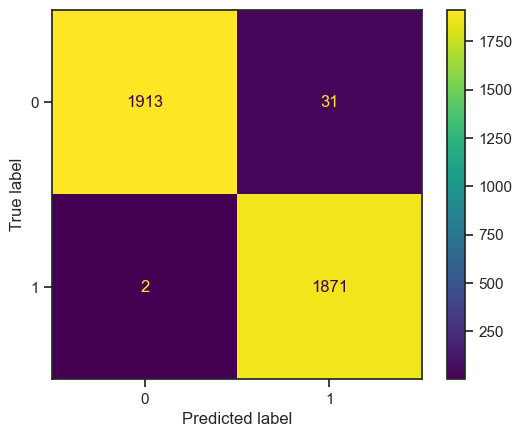

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

test_acc = model.evaluate(test)

y_test = []
for _, label in test:
    y_test += list(np.array(label))


preds = model.predict(test)
preds = np.round(preds)
preds = np.reshape(preds, (preds.shape[0],))

labels = ['claim', 'opinion']
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# f1 score
f1 = f1_score(y_test, preds)

print(f'Loss on Test set: {test_acc[0]}')
print(f'Accuracy on Test set: {test_acc[1]}')
print(f'F1-Score on test set: {f1}')

The accuracy metric reveals that the model is able to generalize almost perfectly with new information (`test` set). Furthermore, the confusion matrix shows that there is a low rate of false positives and false negatives, which is reflected in a high F1-score. Therefore, we can conclude that the model is capable of making reliable predictions.

Finally, the obtained model is saved for possible implementation in some application.

In [25]:
model.save('final_model')

INFO:tensorflow:Assets written to: final_model\assets


## 6. Example of use
Finally, a simple example of using the pre-trained model is included. First, the model is loaded with its configuration.

In [28]:
reloaded_model = tf.keras.models.load_model('final_model')

Then, given an input instance, the model is used to make predictions. Note the format of the input, which consists of raw data. Since the model includes the preprocessing pipeline, the model is prepared to receive this type of input, making it easy to deploy without the concern of preprocessing the information beforehand.

In [29]:
# prueba
raw_input = {'video_view_count': 20000, 'video_like_count': 200, 'video_share_count':200, 'video_download_count':20,
             'video_comment_count':50, 'verified_status':'not verified', 'author_ban_status':'active',
             'video_transcription_text': "my colleagues' point of view is that 90% of goods are shipped by ocean freight"}


raw_input = {name: tf.convert_to_tensor([value]) for name, value in raw_input.items()}

pred  = reloaded_model.predict(raw_input)
pred

1/1 [==============================] - 0s 197ms/step


array([[0.70318717]], dtype=float32)